In [118]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler

# descomentar para graficos aparecerem no github
import plotly.io as pio
pio.renderers.default = 'png'    #@param ['svg', 'colab', 'vscode' ]

In [119]:
carteira = 'ibra100'

In [120]:
url0 = 'https://raw.githubusercontent.com/BDonadelli/Finance-playground/refs/heads/main/data/'

url  = {'ibra50' :url0+'Cart_IBr50.csv',
        'ibra100':url0+'Cart_IBr100.csv',
        'idiv'   :url0+'Cart_Idiv.csv',
        'ibov'   :url0+'Cart_Ibov.csv',
        'small'  :url0+'Cart_Small.csv'
}
indice = pd.read_csv(url[carteira] ,
                     sep=';' , decimal=',' , thousands='.' ,
                     skiprows=1,skipfooter=2,
                     encoding='latin-1',
                     index_col=False , engine='python')

indice

,Código,Ação,Tipo,Qtde. Teórica,Part. (%)
0,ALOS3,ALLOS,ON ED NM,476976044,0.445
1,ALPA4,ALPARGATAS,PN N1,164391149,0.054
2,ABEV3,AMBEV S/A,ON,4394835131,2.735
3,AMBP3,AMBIPAR,ON NM,37603389,0.235
4,ASAI3,ASSAI,ON ED NM,1345832968,0.548
...,...,...,...,...,...
96,VAMO3,VAMOS,ON NM,485166826,0.115
97,VBBR3,VIBRA,ON ED NM,1023538460,0.864
98,VIVA3,VIVARA S.A.,ON ED NM,125446075,0.117
99,WEGE3,WEG,ON NM,1482105837,3.266


In [121]:
df_ibov = indice['Código']
tickers = [codigo + '.SA' for codigo in df_ibov.tolist()]
periodo = '90d'
data = yf.download(tickers, period=periodo, interval='1d', group_by='ticker', auto_adjust=True, threads=True)

[*********************100%***********************]  101 of 101 completed


**1. Índice Simplificado usando Variação e Volume de Ações**

$$
\text{Índice de Sentimento} = \frac{\sum (V_i \cdot S_i)}{\sum \left| V_i \cdot S_i \right|}
$$

Onde:
- \( V_i \): volume financeiro negociado da ação \( i \),
- \( S_i \): sinal da variação diária da ação \( i \)  
  (\(+1\) para alta, \(-1\) para queda).

**Interpretação**

- Valor próximo de **+1**: mercado muito otimista
- Valor próximo de **-1**: mercado em pânico
- Valor próximo de **0**: sentimento neutro


In [122]:
datas = data.index
df_resultado = pd.DataFrame(index=datas[1:])
indices = []

for i in range(1, len(datas)):
    dia_atual = datas[i]
    dia_anterior = datas[i - 1]

    soma_num = 0
    soma_den = 0

    for ticker in tickers:
        try:
            preco_atual = data[ticker]['Close'].loc[dia_atual]
            preco_anterior = data[ticker]['Close'].loc[dia_anterior]
            volume = data[ticker]['Volume'].loc[dia_atual]

            retorno = (preco_atual - preco_anterior) / preco_anterior
            sinal = 1 if retorno > 0 else (-1 if retorno < 0 else 0)

            soma_num += volume * sinal
            soma_den += abs(volume * sinal)

        except Exception:
            continue

    indice = soma_num / soma_den if soma_den != 0 else 0
    indices.append(indice)

df_resultado['Indice_Sentimento'] = indices

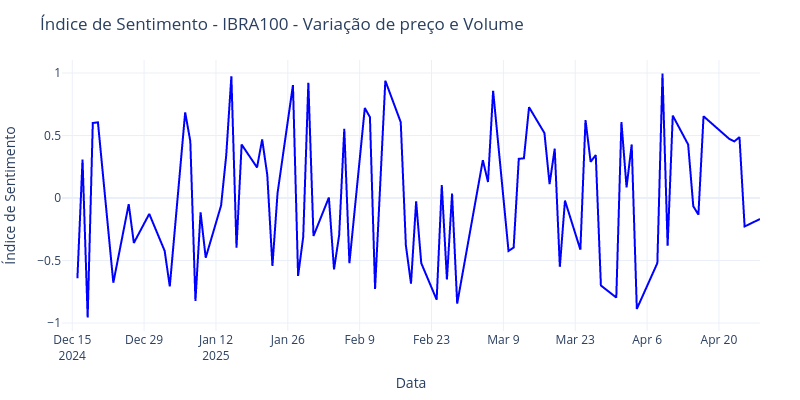

In [123]:
fig = go.Figure()
## ------------------------------
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaled_features = scaler.fit_transform(df_resultado[['Indice_Sentimento']])
# scaled_df_volume = pd.DataFrame(scaled_features, columns=['Indice_Sentimento'], index=df_resultado.index)
scaled_df_volume = df_resultado.copy()
## ------------------------------

fig.add_trace(go.Scatter(x=scaled_df_volume.index,y=scaled_df_volume['Indice_Sentimento'],mode='lines',
    name=f'Índice de Sentimento - {carteira}', line=dict(color='blue')))

fig.update_layout(title=f'Índice de Sentimento - {carteira.upper()} - Variação de preço e Volume ',width=800,height=400,#legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),xaxis_title='Data',yaxis_title='Índice de Sentimento',template='plotly_white')

fig.show()

In [124]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
import time
import os

# Pasta onde o arquivo será salvo
download_dir = str(os.getcwd()) + r"/data/"

# Configurações do Chrome
chrome_options = Options()
chrome_options.add_experimental_option('prefs', {
    "download.default_directory": download_dir,  # muda a pasta de download
    "download.prompt_for_download": False,       # não pede confirmação
    "directory_upgrade": True,
    "safebrowsing.enabled": True
})


*Índice com dados de fluxo (investidor estrangeiro vs local)*
$$
\text{Indice de fluxo} = \frac{\text{Fluxo Lıquido Estrangeiro}}{\text{Volume Total}}
$$ 
Se o índice estiver muito positivo: otimismo externo (gringos comprando).

Se estiver muito negativo: pânico (gringos vendendo pesado).



In [125]:
driver=webdriver.Chrome(options=chrome_options)
url='https://www.dadosdemercado.com.br/bolsa/investidores-estrangeiros'
driver.get(url)
time.sleep(2)
path='//*[@id="download-csv"]'
botao = driver.find_element(By.XPATH,path)
botao.click()
driver.close()

In [126]:
try:
    os.rename("data/fluxo-estrangeiro (1).csv","data/fluxo-estrangeiro.csv")
except:
    pass

In [127]:
fluxo = pd.read_csv('data/fluxo-estrangeiro.csv')

# Converter a coluna Data para datetime
fluxo['Data'] = pd.to_datetime(fluxo['Data'], format='%d/%m/%Y')

# Função para limpar e converter os valores para float
def converter_valor(valor):
    if isinstance(valor, str):
        # Remove o sufixo " mi"
        valor = valor.replace(' mi', '')
        # Substitui o ponto de milhar e vírgula decimal para formato float padrão
        valor = valor.replace('.', '').replace(',', '.')
        return float(valor)
    return valor

# Aplicar a função para todas as colunas, exceto 'Data'
colunas_valores = fluxo.columns.difference(['Data'])
for col in colunas_valores:
    fluxo[col] = fluxo[col].apply(converter_valor)


fluxo

,Data,Estrangeiro,Institucional,Pessoa física,Inst. Financeira,Outros
0,2025-04-24,882.83,-280.80,-524.64,54.70,-132.10
1,2025-04-23,1671.85,-1210.13,-247.50,67.38,-281.60
2,2025-04-22,1112.86,-935.41,-127.54,-34.45,-15.46
3,2025-04-17,2332.51,-781.91,-273.00,-1326.86,49.25
4,2025-04-16,-1115.98,564.08,113.25,231.88,206.77
...,...,...,...,...,...,...
244,2024-05-06,-128.19,-88.95,194.39,17.70,5.06
245,2024-05-03,1028.27,-522.34,-375.29,-58.40,-72.24
246,2024-05-02,603.67,-623.34,-220.19,17.07,222.79
247,2024-04-30,-1398.73,607.61,529.58,251.08,10.47


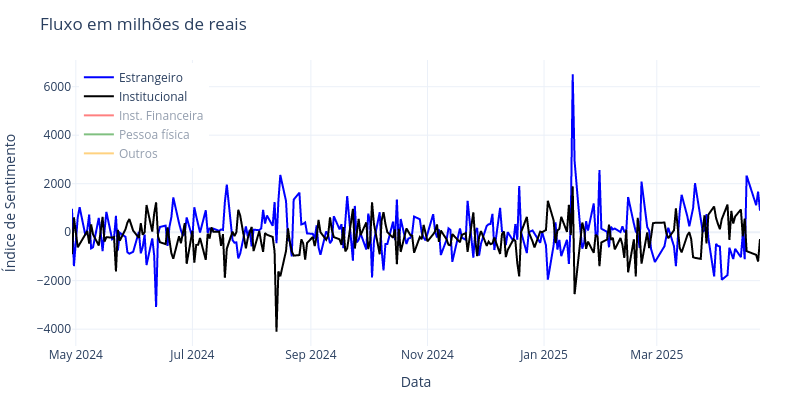

In [128]:
fig = go.Figure()

# Linha principal (o seu índice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Estrangeiro, mode='lines', name='Estrangeiro', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo.Institucional, mode='lines', name='Institucional', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Inst. Financeira'], mode='lines', name='Inst. Financeira', line=dict(color='red'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Pessoa física'], mode='lines', name='Pessoa física', line=dict(color='green'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Outros'], mode='lines', name='Outros', line=dict(color='orange'),
                         visible='legendonly'))
# Layout
fig.update_layout(
    title=f'Fluxo em milhões de reais',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='Índice de Sentimento',
    template='plotly_white'
)

fig.show()

In [129]:

fluxo['Total'] = (fluxo['Estrangeiro']+fluxo['Institucional']+fluxo['Pessoa física']+fluxo['Inst. Financeira']+fluxo['Outros'] 	)
fluxo['Total absluto'] = abs(fluxo['Estrangeiro'])+abs(fluxo['Institucional'])+abs(fluxo['Pessoa física'])+abs(fluxo['Inst. Financeira'])+abs(fluxo['Outros'] 	)
# fluxo['Total2'] = fluxo[colunas_valores].sum(axis=1) 
fluxo['Indice de fluxo'] = fluxo['Estrangeiro']/fluxo['Total absluto']

ext = fluxo['Estrangeiro']
min_e = ext.min()
max_e = ext.max()
# # Índice de Sentimento (Estrangeiros) normalizado entre 0 e 1
fluxo['Indice_Estrangeiro'] = (ext - min_e) / (max_e - min_e)

# # Soma dos fluxos estrangeiro e institucional
fluxo_EI = fluxo['Estrangeiro'] + fluxo['Institucional']
min_ei = fluxo_EI.min()
max_ei = fluxo_EI.max()
# Índice de Sentimento (Estrangeiro + Institucional)
fluxo['Indice_Est_Inst'] = (fluxo_EI - min_ei) / (max_ei - min_ei)

fluxo

,Data,Estrangeiro,Institucional,Pessoa física,Inst. Financeira,Outros,Total,Total absluto,Indice de fluxo,Indice_Estrangeiro,Indice_Est_Inst
0,2025-04-24,882.83,-280.80,-524.64,54.70,-132.10,-1.000000e-02,1875.07,0.470825,0.413405,0.398416
1,2025-04-23,1671.85,-1210.13,-247.50,67.38,-281.60,-2.273737e-13,3478.46,0.480629,0.495615,0.387593
2,2025-04-22,1112.86,-935.41,-127.54,-34.45,-15.46,-7.815970e-14,2225.72,0.500000,0.437372,0.365666
3,2025-04-17,2332.51,-781.91,-273.00,-1326.86,49.25,-1.000000e-02,4763.53,0.489660,0.564450,0.471586
4,2025-04-16,-1115.98,564.08,113.25,231.88,206.77,2.842171e-14,2231.96,-0.500000,0.205144,0.309406
...,...,...,...,...,...,...,...,...,...,...,...
244,2024-05-06,-128.19,-88.95,194.39,17.70,5.06,1.000000e-02,434.29,-0.295171,0.308064,0.335228
245,2024-05-03,1028.27,-522.34,-375.29,-58.40,-72.24,-7.105427e-14,2056.54,0.500000,0.428558,0.391003
246,2024-05-02,603.67,-623.34,-220.19,17.07,222.79,-8.526513e-14,1687.06,0.357824,0.384318,0.350460
247,2024-04-30,-1398.73,607.61,529.58,251.08,10.47,1.000000e-02,2797.47,-0.499998,0.175684,0.290954


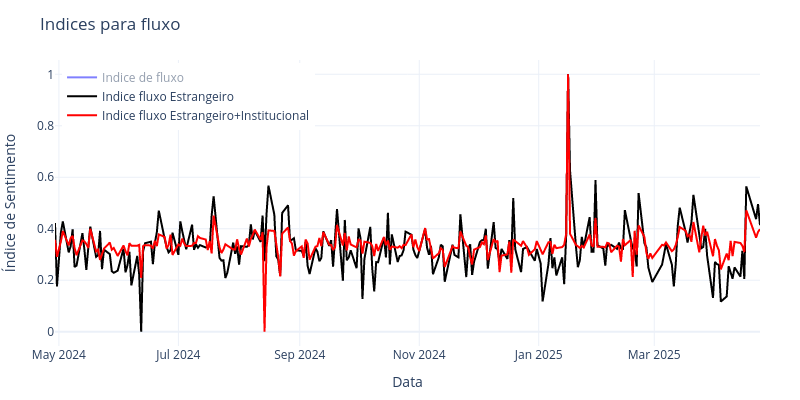

In [130]:
fig = go.Figure()

# Linha principal (o seu índice de sentimento)
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice de fluxo'], mode='lines', name='Indice de fluxo', line=dict(color='blue'),
                         visible='legendonly'))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Estrangeiro'], mode='lines', name='Indice fluxo Estrangeiro', line=dict(color='black')))
fig.add_trace(go.Scatter( x=fluxo.Data, y=fluxo['Indice_Est_Inst'], mode='lines', name='Indice fluxo Estrangeiro+Institucional', line=dict(color='red')))

# Layout
fig.update_layout(
    title=f'Indices para fluxo',
    width=800,
    height=400,
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='Índice de Sentimento',
    template='plotly_white'
)

fig.show()

# VXBR  S&P/B3 Ibovespa VIX

Em termos percentuais, o VIX representa a expectativa anualizada da variação do índice. Assim, um VIX de 24,83 sugere que o mercado espera uma oscilação anualizada de cerca de 24,83% no índice, o que pode ser interpretado como um cenário de incerteza e possível turbulência nos próximos meses.

De forma prática:

$<$ 20 indicam baixa volatilidade, com investidores mais confiantes e dispostos a correr riscos;

Entre 20 e 30 pontos o mercado está em uma faixa de volatilidade média, sinalizando um risco moderado e maior incerteza;

$>$ 30 pontos, o índice sinaliza alta volatilidade e maior nervosismo ou medo dos investidores, indicando oscilações fortes nos preços dos ativo

A S&P Dow Jones Indices (S&P DJI) e a B3 lançaram o S&P/B3 Ibovespa VIX, o primeiro índice de volatilidade implícita do mercado brasileiro, baseado na metodologia do famoso índice VIX da Cboe Global Markets. O novo índice mede a volatilidade implícita de curto prazo nas opções do Ibovespa, oferecendo uma visão de 30 dias sobre a expectativa de volatilidade no Brasil ele serve como referência para avaliar o sentimento do mercado e o risco percebido.

In [131]:
driver = webdriver.Chrome(options=chrome_options)
driver.get("https://www.spglobal.com/spdji/pt/indices/indicators/sp-b3-ibovespa-vix/#overview")
time.sleep(2)
botao1 = driver.find_element(By.ID, "onetrust-accept-btn-handler")
botao1.click()
time.sleep(2)
botao2 =  driver.find_element(By.CLASS_NAME, "optanon-allow-all")
botao2.click()
time.sleep(5)
driver.execute_script("window.scrollBy(0, 500);")  # Scroll para o botão aparecer
exportar = driver.find_element(By.XPATH, "//a[contains(text(), 'Exportar')]")
exportar.click()
driver.quit()


In [132]:

# Caminho para o arquivo
arquivo = 'data/PerformanceGraphExport.xls'
# Primeiro, ler o arquivo bruto sem cabeçalho
df_raw = pd.read_excel(arquivo, header=None)

# Encontrar a linha onde aparece 'Data efetiva' e 'S&P/B3 Ibovespa VIX'
header_row = None
for i, row in df_raw.iterrows():
    if 'Data efetiva' in row.values and 'S&P/B3 Ibovespa VIX' in row.values:
        header_row = i
        break

if header_row is None:
    raise ValueError("Não encontrei a linha de cabeçalho com 'Data efetiva' e 'S&P/B3 Ibovespa VIX'!")

# Ler de novo pulando até o header_row
vixbr = pd.read_excel(arquivo, skiprows=header_row)

# Selecionar só as colunas que interessam
vixbr = vixbr[['Data efetiva', 'S&P/B3 Ibovespa VIX']]

# Tentar converter 'Data efetiva' para datetime
vixbr['Data efetiva'] = pd.to_datetime(vixbr['Data efetiva'], errors='coerce')

# Remover linhas que não têm data válida
vixbr = vixbr.dropna(subset=['Data efetiva'])

vixbr = vixbr.reset_index(drop=True)
vixbr.columns = ['Data', 'VX']
vixbr[['Data', 'VX']] = vixbr[['Data', 'VX']].apply(pd.to_numeric, errors='coerce')
vixbr['Data'] = pd.to_datetime(vixbr['Data'])
vixbr['VX-diario'] = vixbr['VX'] / (365**(1/2))
vixbr['VX-mes'] = vixbr['VX'] / (12**(1/2))
vixbr=vixbr.set_index('Data')
vixbr

,VX,VX-diario,VX-mes
Data,,,
2024-04-25,16.85,0.881969,4.864176
2024-04-26,16.44,0.860509,4.745819
2024-04-29,16.39,0.857892,4.731385
2024-04-30,16.87,0.883016,4.869950
2024-05-02,17.05,0.892438,4.921911
...,...,...,...
2025-04-17,17.94,0.939023,5.178832
2025-04-22,18.40,0.963100,5.311622
2025-04-23,18.16,0.950538,5.242340


In [133]:
# vix sp500

vix = yf.download('^VIX' , start= vixbr.index[0].date(), end= vixbr.index[-1].date(), interval='1d', auto_adjust=True, threads=True)['Close']
# vix_alinhado = vix.reindex(df.index).ffill() # Garantir que o índice do VIX é igual ao do DF e preenche valores faltantes para frente
vix['VIX-diario'] = vix['^VIX'] / (365**(1/2))
vix['VIX-mes']    = vix['^VIX'] / (12**(1/2))
vix

[*********************100%***********************]  1 of 1 completed


Ticker,^VIX,VIX-diario,VIX-mes
Date,,,
2024-04-25,15.370000,0.804503,4.436937
2024-04-26,15.030000,0.786706,4.338787
2024-04-29,14.670000,0.767863,4.234864
2024-04-30,15.650000,0.819158,4.517766
2024-05-01,15.390000,0.805549,4.442710
...,...,...,...
2025-04-17,29.650000,1.551952,8.559218
2025-04-21,33.820000,1.770220,9.762993
2025-04-22,30.570000,1.600107,8.824799


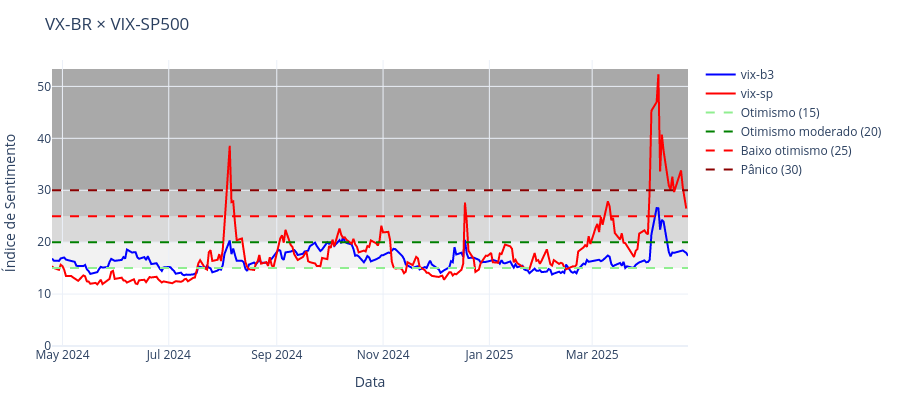

In [134]:
fig = go.Figure()

df=vixbr.copy()

fig.add_trace(go.Scatter( x=df.index, y=df.VX, mode='lines', name=f'vix-b3', line=dict(color='blue')))
fig.add_trace(go.Scatter( x=vix.index , y=vix['^VIX'].values, mode='lines', name=f'vix-sp', line=dict(color='red')))

# Linha de Otimismo (15)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[15, 15], mode='lines', name='Otimismo (15)',
    line=dict(color='lightgreen', dash='dash')))
# Linha de Otimismo moderado (20)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[20, 20], mode='lines', name='Otimismo moderado (20)',
    line=dict(color='green', dash='dash')))
# Linha de Baixo otimismo (25)
fig.add_trace(go.Scatter( x=[df.index.min(), df.index.max()], y=[25, 25], mode='lines', name='Baixo otimismo (25)',
    line=dict(color='red', dash='dash')))
# Linha de Pânico (30)
fig.add_trace(go.Scatter(x=[df.index.min(), df.index.max()],y=[30, 30],mode='lines',name='Pânico (30)',
    line=dict(color='darkred', dash='dash')))

# Faixa < 15 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=0, y1=15,  fillcolor="white", 
    opacity=0, layer="below",  line_width=0, )
# Faixa 15-20 
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=15, y1=20,  fillcolor="lightgrey", 
    opacity=0.3, layer="below",  line_width=0, )
# Faixa 20-25
fig.add_shape( type="rect",x0=df.index.min(), x1=df.index.max(), y0=20, y1=25, fillcolor="grey",  
    opacity=0.3,layer="below", line_width=0,)
# Faixa 25-30
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=25, y1=30,fillcolor="darkgrey",  
    opacity=0.7,layer="below",line_width=0,)
# Faixa >30 
fig.add_shape(type="rect",x0=df.index.min(), x1=df.index.max(),y0=30, y1=max([vix['^VIX'].max(),df.VX.max()])+1,fillcolor="darkgrey",  
    opacity=1,layer="below",line_width=0,)

# Layout
fig.update_layout(
    title=r'VX-BR × VIX-SP500',
    width=900,
    height=400,
    # legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis_title='Data',
    yaxis_title='Índice de Sentimento',
    template='plotly_white'
)

fig.show()

df=[]


In [135]:
vixes = pd.concat([vixbr['VX-diario'],vix['VIX-diario']],axis=1, join='inner')


In [136]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_vix = pd.DataFrame(scaler.fit_transform(vixbr), columns=vixbr.columns, index=vixbr.index)

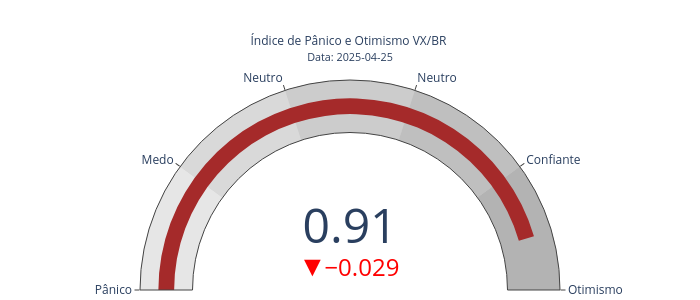

In [137]:
# 5. Gauge
indice_atual = vixbr['VX-diario'].iloc[-1]
indice_ontem = vixbr['VX-diario'].iloc[-2]
variacao = indice_atual - indice_ontem
data_ult = vixbr.index[-1].strftime('%Y-%m-%d')

fig = go.Figure(go.Indicator(
    mode="gauge+number+delta",
    value=indice_atual,
    delta={'reference': indice_ontem, 'increasing': {'color': "green"}, 'decreasing': {'color': "red"}},
    number={'font': {'size': 48}},
    gauge={
        'axis': {'range': [0, 1], 'tickvals': [0, 0.2, 0.4, 0.6, 0.8, 1], 
                 'ticktext': ['Pânico', 'Medo', 'Neutro', 'Neutro', 'Confiante', 'Otimismo']},
        'bar': {'color': 'brown', 'thickness': 0.3},
        'bgcolor': "lightgray",
        'steps': [
            {'range': [0, 0.2], 'color': '#e6e6e6'},
            {'range': [0.2, 0.4], 'color': '#d9d9d9'},
            {'range': [0.4, 0.6], 'color': '#cccccc'},
            {'range': [0.6, 0.8], 'color': '#bfbfbf'},
            {'range': [0.8, 1.0], 'color': '#b3b3b3'}
        ],
    },
    title={'text': f"Índice de Pânico e Otimismo VX/BR <br><span style='font-size:0.9em'>Data: {data_ult}</span>"}
))

fig.update_layout(height=300, margin={'t': 80, 'b': 10})
fig.show()


**Índice de Pânico nas Bolsas de Valores** O cálculo do índice de pânico nos mercados financeiros está intrinsecamente ligado à medição da volatilidade implícita, com o VIX (Volatility Index) emergindo como principal referência global. Desenvolvido pelo *Chicago Board Options Exchange* (CBOE) em 1993, esse indicador quantifica as expectativas de *oscilações no S&P 500 para os próximos 30 dias*, servindo como termômetro do medo ou euforia dos investidores. No Brasil, a B3 implementou uma versão adaptada, o VXBR, que segue a mesma metodologia aplicada ao Ibovespa. Este relatório explora os fundamentos matemáticos, as variações regionais e as aplicações práticas desses índices.

**Fundamentos Teóricos da Volatilidade Implícita** O VIX calcula a volatilidade esperada utilizando preços de opções de compra (call) e venda (put) do S&P 500. Esses derivativos funcionam como contratos de seguro contra movimentos bruscos nos preços, onde *opções de compra refletem apostas em alta* e *opções de venda indicam proteção contra quedas*. A fórmula do VIX, conforme detalhada pela metodologia do CBOE:
$$
\sigma^2 =  \frac 2T \sum  \frac{\Delta K_i}{K_i^2}\exp(RT)Q(K_i) - \frac 1T\left(\frac F{K_0} - 1\right)^2
$$
onde:
𝜎² : Variância da volatilidade implícita;
T: Tempo até expiração das opções;
Ki : Preços de exercício das opções;
Q(Ki): Preço médio das opções;
F: Preço futuro do índice.

**Metodologia de Cálculo Prático**

*Seleção de Séries Temporais*: Coletar preços de opções do S&P 500 com vencimentos em 23 e 37 dias, garantindo janela móvel de 30 dias

*Cálculo de Variâncias*: Para cada expiration date, computar a variância implícita usando a fórmula de Neuberger (1990), que pondera contribuições de diferentes strikes

*Interpolação Temporal*: Combinar as variâncias dos contratos próximos (near-term) e seguintes (next-term) para obter volatilidade anualizada:
$$
\text{VIX} = 100 \times \sqrt{ \left( T_1 \sigma_1^2 \frac{N_{T2} - N_{30}}{N_{T2} - N_{T1}} \right) + \left( T_2 \sigma_2^2 \frac{N_{30} - N_{T1}}{N_{T2} - N_{T1}} \right) } \times \frac{365}{30}
$$
onde $N_{T_x}$ representa dias até expiração.

**Adaptação Brasileira: VXBR** (Especificidades do Índice B3/S&P Ibovespa VIX) Lançado em março de 2024, o VXBR replica a metodologia do VIX original porém utilizando opções do Ibovespa. Durante crises, como a alta de 476% no VIX global em março de 2020, o índice brasileiro demonstra sensibilidade comparável. Seu cálculo automático considera:
1. Liquidez das opções do IBOV;
2. Ajustes sazonais no vencimento;
3. Prazos mínimos de 30 dias para evitar distorções.

**Desafios na Implementação Local**
Diferentemente do mercado americano, *a baixa liquidez de derivativos no Brasil* exige filtros adicionais para excluir strikes sem negociação, potencialmente introduzindo viés amostral. A B3 realiza rodadas de ajuste metodológico periódicas para mitigar esses efeitos. 

**Alternativas Computacionais: Índice Medo vs. Ganância** -
*Abordagem Multifatorial* - 
O Fear & Greed Index, popularizado pela CNN, combina sete variáveis ponderadas:

vix * 0.05 + putCallRatio * 0.1 + marketBreadth * 0.15 + junkBonds * 0.2 +  safeHavenDemand * 0.25 + treasuryYield * 0.15 +  peRatio * 0.1

Nesse modelo, cada fator captura diferentes dimensões de risco:
1. Demanda por títulos do Tesouro (25%): Refúgios seguros indicam medo;
2. Bonds de alto risco (20%): Aceitação de risco corporativo sinaliza ganância;
3. Razão Put/Call (10%): Mais puts sugerem hedging contra quedas.

**Limitações Metodológicas**
Enquanto o VIX deriva diretamente de dados de mercado, índices compostos como o Fear & Greed dependem de escolhas subjetivas na ponderação de fatores. Estudos apontam correlação de apenas 0.65 entre ambas as métricas em períodos de estresse.

**Aplicações Práticas para Investidores**

*Estratégias de Hedge*
Fundos institucionais utilizam o VIX para calibrar proteções:
1. Quando o VIX supera 30, gestores aumentam exposição em opções de venda;
2. Abaixo de 15, reduzem custos de hedge priorizando calls.

*Sinal Contrário (Contrarian Indicator)*
Extremos históricos do VIX (>40 ou <15) marcaram pontos de reversão de mercado em 82% dos casos desde 1990. Por exemplo: Pico de 89.53 em outubro de 2008 (crise Lehman Brothers); Mínimo de 9.51 em novembro de 2017 (expansão monetária pós-crise).

**Perspectivas Futuras e Inovações**

*Modelos Machine Learning*
Pesquisas recentes testam redes neurais LSTM para prever o VIX usando:
1. Dados de sentimento em redes sociais;
2. Fluxos de ordens em dark pools;
3. Indicadores macroeconômicos em tempo real.

Resultados preliminares mostram redução de 20% no erro quadrático médio versus modelos ARIMA tradicionais.

**VIX Setoriais**
Derivativos segmentados por setores (tecnologia, energia) estão em desenvolvimento, permitindo hedge específico. O CBOE Sector VIX para tech já representa 12% do mercado de volatilidade6.

**Conclusão e Recomendações**
O cálculo do índice de pânico envolve tanto complexidade matemática quanto compreensão comportamental. Para investidores brasileiros, monitorar o VXBR oferece insights valiosos, porém é crucial:

Validar contra dados locais de liquidez;

Combinar com indicadores globais para evitar miopias regionais;

Utilizar simulações de Monte Carlo para testar estratégias de hedge.

Institutos de pesquisa sugerem a integração de modelos híbridos, combinando VIX tradicional com dados alternativos (geopolítica, clima) para antecipar crises sistêmicas. A evolução contínua desses índices reforça seu papel como bússolas em oceanos de incerteza financeira

# testes

In [138]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


dados = data
resultado = pd.DataFrame()
for acao in tickers:
    df = dados[acao].copy()
    df['Return'] = df['Close'].pct_change()
    df['Volatility'] = df['Return'].rolling(window=7).std()
    df['High-Low Range'] = (df['High'] - df['Low']) / df['Low']
    df = df[['Return', 'Volatility', 'High-Low Range']]
    df.columns = [f'{acao}_Return', f'{acao}_Volatility', f'{acao}_HLRange']
    
    if resultado.empty:
        resultado = df
    else:
        resultado = resultado.join(df)

resultado = resultado.dropna()

# Indicador de número de ações subindo/caindo
# 1 para subida, -1 para queda
up_down = resultado[[col for col in resultado.columns if 'Return' in col]].apply(lambda x: np.where(x > 0, 1, -1))
resultado['Acoes_Subindo'] = up_down.sum(axis=1) / len(tickers)

# Agora normalizar tudo
features = [col for col in resultado.columns if ('Return' in col or 'Volatility' in col or 'HLRange' in col)] + ['Acoes_Subindo']

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(resultado[features])

scaled = pd.DataFrame(scaled_features, columns=features, index=resultado.index)

# Cálculo final do Índice de Pânico/Otimismo
scaled['Panic Optimism Index'] = scaled.mean(axis=1)

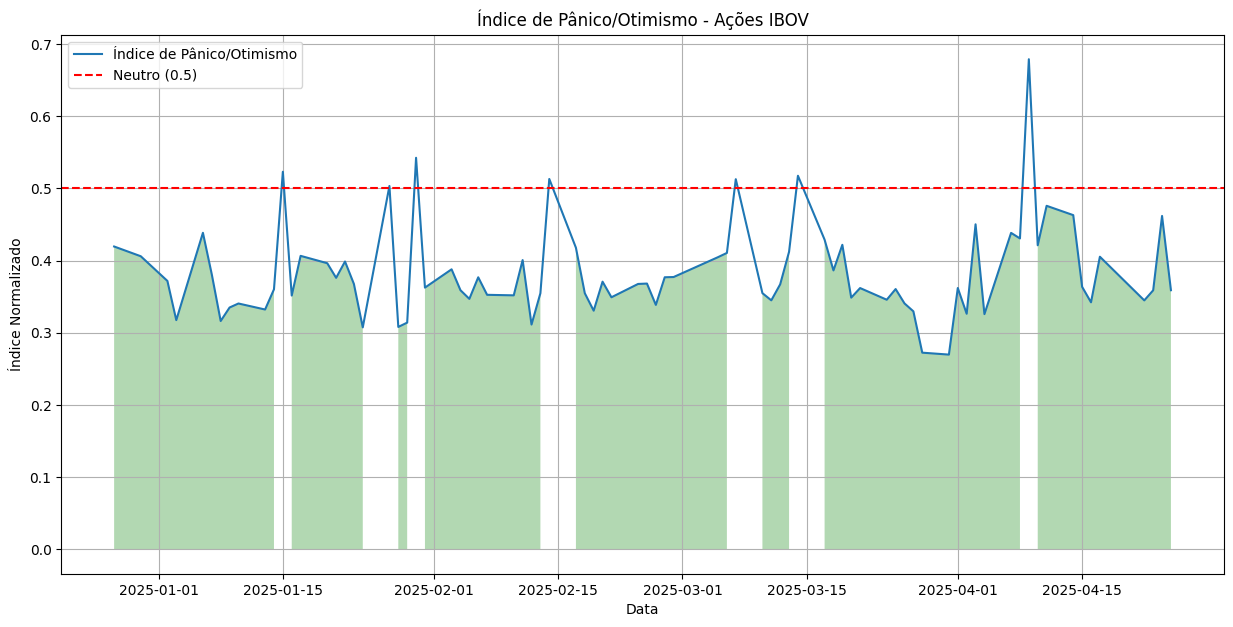

In [139]:
plt.figure(figsize=(15,7))
plt.plot(scaled.index, scaled['Panic Optimism Index'], label='Índice de Pânico/Otimismo')
plt.axhline(0.5, color='red', linestyle='--', label='Neutro (0.5)')
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']>=0.5, facecolor='red', alpha=0.3)
plt.fill_between(scaled.index, 0, scaled['Panic Optimism Index'], where=scaled['Panic Optimism Index']<0.5, facecolor='green', alpha=0.3)
plt.title('Índice de Pânico/Otimismo - Ações IBOV')
plt.xlabel('Data')
plt.ylabel('Índice Normalizado')
plt.legend()
plt.grid(True)
plt.show()

## tesouro direto

Tesouro -- https://www.tesourotransparente.gov.br/ckan/dataset/vendas-do-tesouro-direto



In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'data/VendasTesouroDireto.csv'
df = pd.read_csv(file_path,sep=';', decimal=',', skiprows=0)

df.head()

,Tipo Titulo,Vencimento do Titulo,Data Venda,PU,Quantidade,Valor
0,Tesouro IGPM+ com Juros Semestrais,01/07/2005,17/06/2002,1099.100000,0.2,219.82
1,Tesouro Selic,16/02/2005,18/06/2002,1302.210097,82.2,107041.66
2,Tesouro Selic,18/01/2006,18/06/2002,1276.380000,8.0,10211.04
3,Tesouro IGPM+ com Juros Semestrais,01/04/2008,02/09/2002,1067.290000,8.0,8538.32
4,Tesouro IGPM+ com Juros Semestrais,01/01/2031,02/09/2002,1436.950000,2.0,2873.90


In [141]:
df['Vencimento do Titulo'] = pd.to_datetime(df['Vencimento do Titulo'], dayfirst=True) 
df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True) 

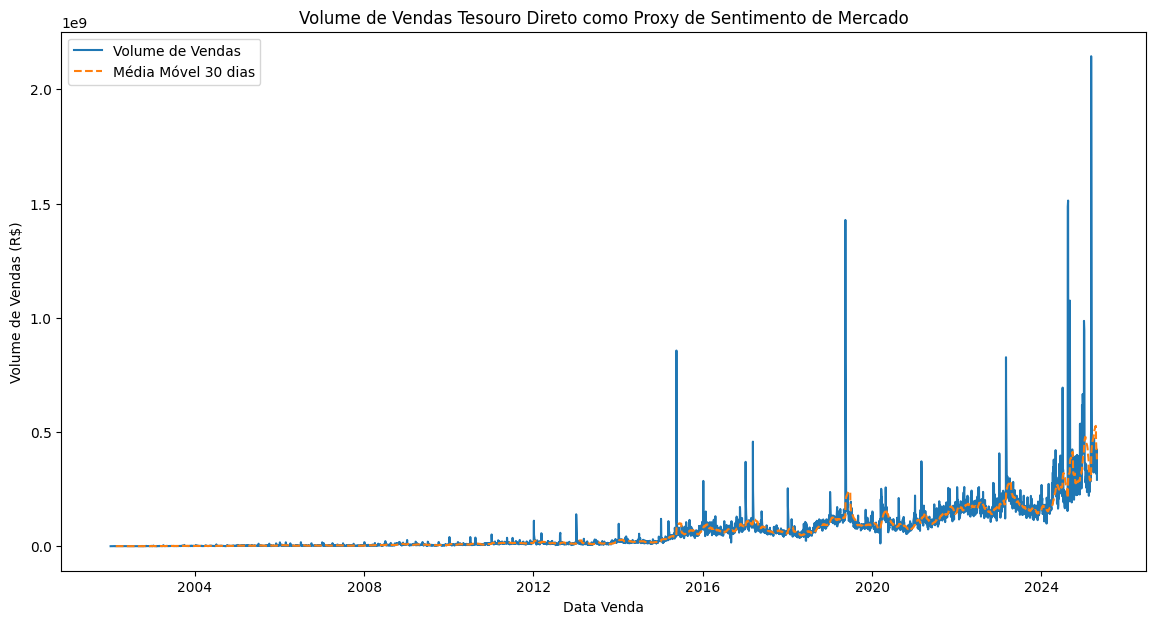

In [142]:
'''
Se o volume de compra for muito alto → Indicativo de medo.
Se for baixo → Indicativo de otimismo.

(Opcional) Normalizar o volume para remover efeitos sazonais ou tendências de longo prazo.

Plotar um gráfico (ex: matplotlib/seaborn) para visualizar isso.
'''

teste1 = df.copy()
# Agrupar por dia o volume de vendas
vendas_diarias = teste1.groupby('Data Venda')['Valor'].sum().reset_index()
# Criar uma métrica de sentimento
# normalizar usando a média móvel de 30 dias
vendas_diarias['MediaMovel30'] = vendas_diarias['Valor'].rolling(window=30).mean()

# Definir Sentimento: medo se vendas > média móvel, otimismo se < média móvel
vendas_diarias['Sentimento'] = vendas_diarias['Valor'] > vendas_diarias['MediaMovel30']
vendas_diarias['Sentimento'] = vendas_diarias['Sentimento'].map({True: 'Medo', False: 'Otimismo'})

# Visualizar
plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_diarias, x='Data Venda', y='Valor', label='Volume de Vendas')
sns.lineplot(data=vendas_diarias, x='Data Venda', y='MediaMovel30', label='Média Móvel 30 dias', linestyle='--')
plt.title('Volume de Vendas Tesouro Direto como Proxy de Sentimento de Mercado')
plt.xlabel('Data Venda')
plt.ylabel('Volume de Vendas (R$)')
plt.legend()
plt.show()

In [143]:
df.columns

Index(['Tipo Titulo', 'Vencimento do Titulo', 'Data Venda', 'PU', 'Quantidade',
       'Valor'],
      dtype='object')

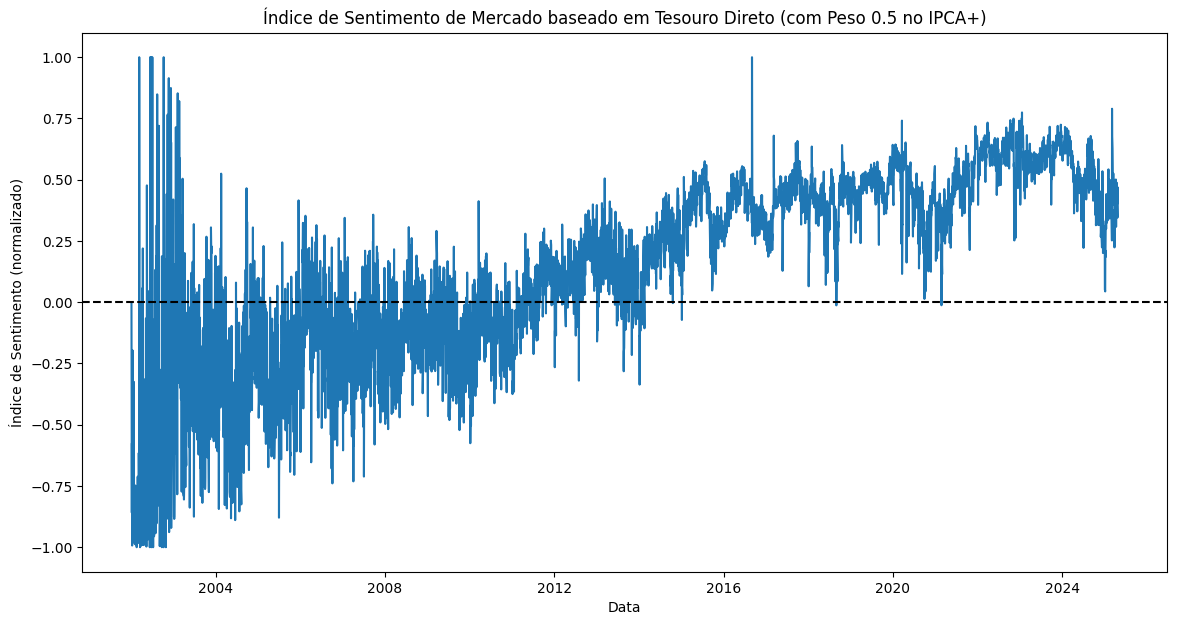

In [144]:
''''
Agrupar o volume diário para cada tipo
Criar uma "pontuação" de sentimento para cada tipo:
Tesouro Selic → Peso +1 para medo.
Tesouro IPCA+ → Peso 0.5 medo moderado.
Tesouro Prefixado → Peso -1 para otimismo.
Calcular um índice de sentimento diário combinando essas pontuações.
'''
teste2=df.copy()
#  Categorizar tipos de título para sentimento
def classificar_sentimento(titulo):
    titulo = titulo.lower()
    if 'selic' in titulo:
        return 'Seguro'  # Medo forte
    elif 'ipca' in titulo:
        return 'Intermediario'  # Medo moderado
    elif 'prefixado' in titulo or 'pre' in titulo or 'educa' in titulo or 'renda+' in titulo:
        return 'Arriscado'  # Otimismo
    else:
        return 'Outro'

teste2['Categoria'] = teste2['Tipo Titulo'].apply(classificar_sentimento)

# Agregar volume por dia e categoria
vendas_categorias = teste2.groupby(['Data Venda', 'Categoria'])['Valor'].sum().unstack(fill_value=0)

#  Definir novos pesos de sentimento
pesos = {
    'Seguro': +1,
    'Intermediario': +0.5,
    'Arriscado': -1,
    'Outro': 0
}

#  Calcular o índice de sentimento
vendas_categorias['Indice_Sentimento'] = (
    vendas_categorias['Seguro'] * pesos['Seguro'] +
    vendas_categorias['Intermediario'] * pesos['Intermediario'] +
    vendas_categorias['Arriscado'] * pesos['Arriscado']
)

#  normalizar pelo volume total diário
vendas_categorias['Indice_Sentimento_Normalizado'] = vendas_categorias['Indice_Sentimento'] / (
    vendas_categorias[['Seguro', 'Intermediario', 'Arriscado']].sum(axis=1) + 1e-9
)

plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_categorias, x=vendas_categorias.index, y='Indice_Sentimento_Normalizado')
plt.axhline(0, color='black', linestyle='--')
plt.title('Índice de Sentimento de Mercado baseado em Tesouro Direto (com Peso 0.5 no IPCA+)')
plt.xlabel('Data')
plt.ylabel('Índice de Sentimento (normalizado)')
plt.show()


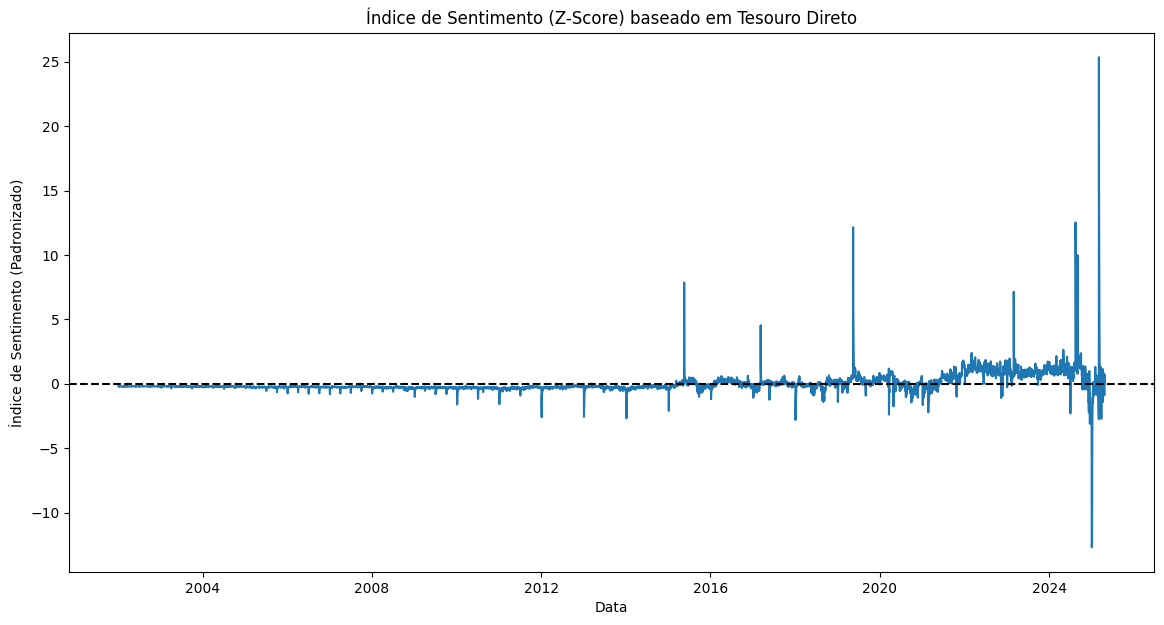

In [145]:
'''
Calcular volume diário por categoria (Seguro, Intermediario, Arriscado).
Calcular z-score: Calcular z-score de volume para cada categoria 
Aplicar pesos: (Selic) → +1 (IPCA+) → +0.5 (Prefixado, Educa+) → -1
Somar tudo para construir um índice contínuo de sentimento padronizado.
'''
from scipy.stats import zscore

# # Carregar e tratar os dados
# df = pd.read_csv('/mnt/data/VendasTesouroDireto.csv', sep=';', encoding='latin1')
# df.columns = df.columns.str.replace('"', '').str.strip()
# df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True)
# # Categorizar tipos de título
# def classificar_sentimento(titulo):
#     titulo = titulo.lower()
#     if 'selic' in titulo:
#         return 'Seguro'
#     elif 'ipca' in titulo:
#         return 'Intermediario'
#     elif 'prefixado' in titulo or 'pre' in titulo or 'educa' in titulo or 'renda+' in titulo:
#         return 'Arriscado'
#     else:
#         return 'Outro'
# df['Categoria'] = df['Tipo Titulo'].apply(classificar_sentimento)
# # Agregar volume por dia e categoria
# vendas_categorias = df.groupby(['Data Venda', 'Categoria'])['Valor'].sum().unstack(fill_value=0)

# Calcular z-score para cada categoria
vendas_categorias_z = vendas_categorias.copy()
for categoria in ['Seguro', 'Intermediario', 'Arriscado']:
    if categoria in vendas_categorias.columns:
        vendas_categorias_z[categoria] = zscore(vendas_categorias[categoria].fillna(0))

# #  Aplicar pesos
# pesos = {
#     'Seguro': +1,
#     'Intermediario': +0.5,
#     'Arriscado': -1,
#     'Outro': 0  # Não estamos usando "Outro"
# }

vendas_categorias_z['Indice_Sentimento_ZScore'] = (
    vendas_categorias_z['Seguro'] * pesos['Seguro'] +
    vendas_categorias_z['Intermediario'] * pesos['Intermediario'] +
    vendas_categorias_z['Arriscado'] * pesos['Arriscado']
)

# Visualizar
plt.figure(figsize=(14,7))
sns.lineplot(data=vendas_categorias_z, x=vendas_categorias_z.index, y='Indice_Sentimento_ZScore')
plt.axhline(0, color='black', linestyle='--')
plt.title('Índice de Sentimento (Z-Score) baseado em Tesouro Direto')
plt.xlabel('Data')
plt.ylabel('Índice de Sentimento (Padronizado)')
plt.show()

In [146]:
ibovespa = yf.download('^BVSP', start = teste1['Data Venda'].min() , end= teste1['Data Venda'].max())[['Close']]
ibovespa = ibovespa.reset_index(drop=False)
ibovespa.columns = ['Date', 'Close']  # força os nomes corretos
ibovespa.head(2)

[*********************100%***********************]  1 of 1 completed


,Date,Close
0,2002-01-04,14332.0
1,2002-01-07,14379.0


Correlação entre Sentimento (z-score) e Retorno do IBOV: 0.1204
                            OLS Regression Results                            
Dep. Variable:                Retorno   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Mon, 28 Apr 2025   Prob (F-statistic):                nan
Time:                        22:23:27   Log-Likelihood:                    nan
No. Observations:                5733   AIC:                               nan
Df Residuals:                    5731   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

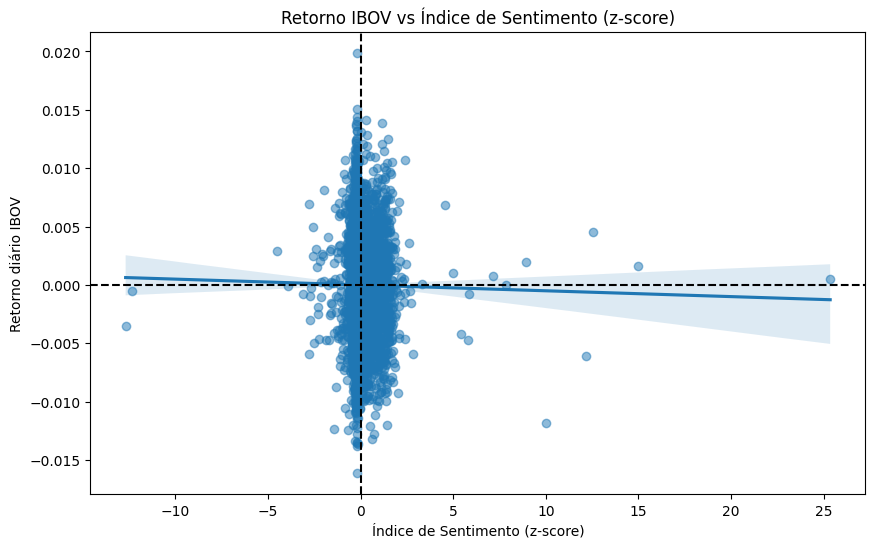

In [147]:
from scipy.stats import linregress
import statsmodels.api as sm

# Índice de Sentimento (calculado antes)
# Vamos assumir que 'vendas_categorias_z' já foi criado, com a coluna 'Indice_Sentimento_ZScore'

# Aqui, vamos fazer uma dummy para exemplificar
# Remover abaixo quando tiver dados reais

np.random.seed(42)
ibov = pd.DataFrame(index=vendas_categorias_z.index)
ibovespa['Close'] = 100000 + np.cumsum(np.random.normal(0, 500, size=len(ibovespa)))

# Calcular retorno diário do IBOVESPA
ibovespa['Retorno'] = ibovespa['Close'].pct_change()

# Juntar as bases
# sentimento_ibov = vendas_categorias_z[['Indice_Sentimento_ZScore']].join(ibovespa[['Retorno']]).dropna()
# df_preco_reset = ibovespa[['Retorno']].reset_index()  
df_sentimento_reset = vendas_categorias_z[['Indice_Sentimento_ZScore']].reset_index()
# Agora fazer o merge
sentimento_ibov = pd.merge(
    ibovespa,#df_preco_reset,
    df_sentimento_reset,
    left_on='Date', 
    right_on='Data Venda',  
    how='inner')
#  Análise de Correlação
correlacao = sentimento_ibov.corr().iloc[0,1]
print(f"Correlação entre Sentimento (z-score) e Retorno do IBOV: {correlacao:.4f}")

# Regressão Linear
X = sentimento_ibov['Indice_Sentimento_ZScore']
y = sentimento_ibov['Retorno']
X = sm.add_constant(X)  # adiciona intercepto
modelo = sm.OLS(y, X).fit()
print(modelo.summary())
#  Gráfico de dispersão
plt.figure(figsize=(10,6))
sns.regplot(x='Indice_Sentimento_ZScore', y='Retorno', data=sentimento_ibov, scatter_kws={'alpha':0.5})
plt.title('Retorno IBOV vs Índice de Sentimento (z-score)')
plt.xlabel('Índice de Sentimento (z-score)')
plt.ylabel('Retorno diário IBOV')
plt.axhline(0, linestyle='--', color='black')
plt.axvline(0, linestyle='--', color='black')
plt.show()

In [148]:
#  Análise com defasagem (sentimento de ontem vs retorno de hoje)
sentimento_ibov['Sentimento_Lag1'] = sentimento_ibov['Indice_Sentimento_ZScore'].shift(1)
sentimento_ibov.dropna(inplace=True)
lagged_model = sm.OLS(sentimento_ibov['Retorno'], sm.add_constant(sentimento_ibov['Sentimento_Lag1'])).fit()
print(lagged_model.summary())


                            OLS Regression Results                            
Dep. Variable:                Retorno   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.266
Date:                Mon, 28 Apr 2025   Prob (F-statistic):              0.260
Time:                        22:23:28   Log-Likelihood:                 23399.
No. Observations:                5732   AIC:                        -4.679e+04
Df Residuals:                    5730   BIC:                        -4.678e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.252e-06   5.39e-05     


Estatísticas dos retornos por quantil de sentimento:
                        mean       std  count    Sharpe
Quantil_Sentimento                                     
1                  -0.000060  0.003799   1147 -0.015756
2                   0.000184  0.003918   1146  0.046947
3                   0.000073  0.004516   1146  0.016140
4                  -0.000096  0.003856   1146 -0.024827
5                  -0.000108  0.004278   1147 -0.025194


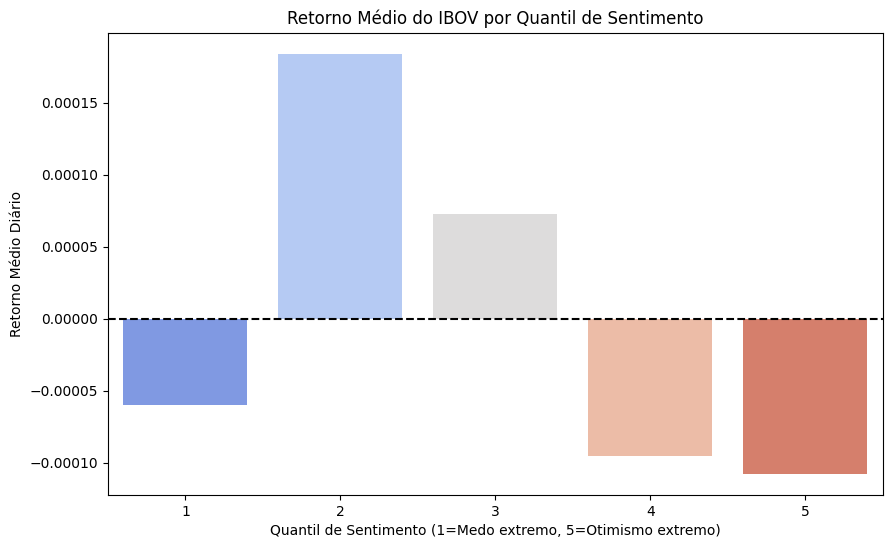


Percentual de dias positivos por quantil:
Quantil_Sentimento
1    0.480384
2    0.513089
3    0.512216
4    0.501745
5    0.492589
Name: Retorno, dtype: float64


In [149]:
''' 
Análise de Quantis:
Quantil 1 (pior sentimento, medo extremo): → Retorno médio do IBOV.
Quantil 5 (melhor sentimento, otimismo extremo): → Retorno médio do IBOV.
Sharpe Ratio em cada quantil: → Risco/retorno ajustado.
% de dias positivos: → Em que quantil o mercado sobe mais vezes.

Quantil	Sentimento	        Esperado para o IBOV
1	    Medo extremo	    Retornos positivos (contrarian) ou negativos (pânico)
5	    Otimismo extremo	Retornos negativos (euforia?) ou positivos (confiança)
Se quando o sentimento está muito ruim (Quantil 1), o IBOV performa melhor, isso mostra um comportamento contrarian: → Comprar quando todos estão com medo.
Se for o contrário, confirma momentum.
'''
# Dividir o sentimento em quantis
sentimento_ibov['Quantil_Sentimento'] = pd.qcut(sentimento_ibov['Indice_Sentimento_ZScore'], 5, labels=[1,2,3,4,5])

# Calcular estatísticas dos retornos em cada quantil
estatisticas_quantis = sentimento_ibov.groupby('Quantil_Sentimento', observed=True)['Retorno'].agg(['mean', 'std', 'count'])
estatisticas_quantis['Sharpe'] = estatisticas_quantis['mean'] / estatisticas_quantis['std']

print("\nEstatísticas dos retornos por quantil de sentimento:")
print(estatisticas_quantis)

#  Gráfico de retornos médios por quantil
plt.figure(figsize=(10,6))
# sns.barplot(x=estatisticas_quantis.index, y='mean', data=estatisticas_quantis, palette="coolwarm")
sns.barplot(x=estatisticas_quantis.index, y='mean', hue=estatisticas_quantis.index, data=estatisticas_quantis, palette="coolwarm", legend=False)
plt.title('Retorno Médio do IBOV por Quantil de Sentimento')
plt.xlabel('Quantil de Sentimento (1=Medo extremo, 5=Otimismo extremo)')
plt.ylabel('Retorno Médio Diário')
plt.axhline(0, linestyle='--', color='black')
plt.show()

# Interpretação adicional: 
# Posso calcular também quantos dias deram retorno positivo/negativo em cada quantil
pos_neg = sentimento_ibov.groupby('Quantil_Sentimento', observed=True)['Retorno'].apply(lambda x: (x > 0).mean())
print("\nPercentual de dias positivos por quantil:")
print(pos_neg)


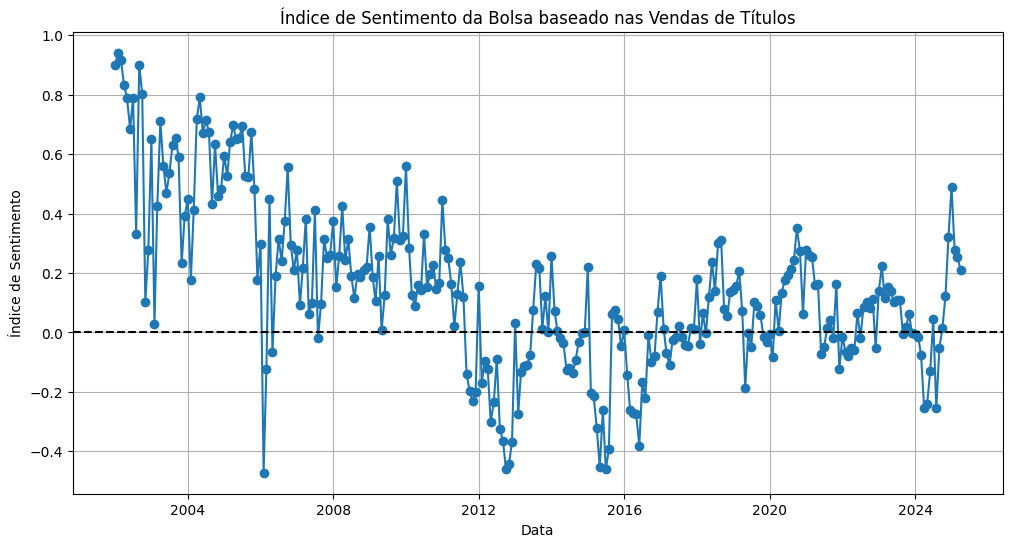

In [150]:
'''
Indice= Venda Otimismo - Venda Medo / Venda Otimismo + Venda Medo
Indice= Venda Otimismo + Venda Medo / Venda Otimismo - Venda Medo
  
Se só venderem prefixado (otimismo), ele dá +1.
Se só venderem IPCA/Selic (medo), ele dá -1.
Se venderem igual, ele dá 0.
'''

df.columns = df.columns.str.strip()
# Converter datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], errors='coerce', dayfirst=True)
#  Filtrar apenas os títulos principais
titulos_otimismo = ['Tesouro Prefixado']
titulos_medo = ['Tesouro Selic', 'Tesouro IPCA+']

# . Separar vendas por tipo
df['Otimismo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_otimismo) else 0)
df['Medo'] = df['Tipo Titulo'].apply(lambda x: 1 if any(t in x for t in titulos_medo) else 0)

# grupar os valores
grupo = df.groupby(df['Data Venda'].dt.to_period('M')).apply(
    lambda x: pd.Series({
        'Venda_Otimismo': x.loc[x['Otimismo']==1, 'Quantidade'].sum(),
        'Venda_Medo': x.loc[x['Medo']==1, 'Quantidade'].sum()}))



grupo = grupo.reset_index()

# Criar o índice de sentimento
# Fórmula: (Venda_Otimismo - Venda_Medo) / (Venda_Otimismo + Venda_Medo)
grupo['Indice_Sentimento'] = (grupo['Venda_Otimismo'] - grupo['Venda_Medo']) / (grupo['Venda_Otimismo'] + grupo['Venda_Medo'])

# 9. Plotar
plt.figure(figsize=(12,6))
plt.plot(grupo['Data Venda'].dt.to_timestamp(), grupo['Indice_Sentimento'], marker='o')
plt.axhline(0, color='black', linestyle='--')
plt.title('Índice de Sentimento da Bolsa baseado nas Vendas de Títulos')
plt.xlabel('Data')
plt.ylabel('Índice de Sentimento')
plt.grid(True)
plt.show()

In [151]:
import pandas as pd

# 1. Carregar o dataframe
df = pd.read_csv('data/VendasTesouroDireto.csv',sep=';',decimal=',')

# 2. Ajustar datas
df['Data Venda'] = pd.to_datetime(df['Data Venda'], dayfirst=True, errors='coerce')

# 3. Filtrar os tipos relevantes
def identificar_tipo(titulo):
    if 'Prefixado' in titulo:
        return 'LTN'
    elif 'IPCA+' in titulo:
        return 'NTN-B'
    elif 'Selic' in titulo:
        return 'LFT'
    else:
        return 'OUTROS'

df['Tipo Simplificado'] = df['Tipo Titulo'].apply(identificar_tipo)

# 4. Agrupar por data e tipo
pivot = df.pivot_table(index='Data Venda', 
                       columns='Tipo Simplificado', 
                       values='Valor', 
                       aggfunc='sum').fillna(0)

# 5. Calcular o volume total
pivot['Total'] = pivot.sum(axis=1)

# 6. Aplicar a fórmula
pivot['Indice Sentimento'] = (pivot.get('LTN', 0) - (pivot.get('NTN-B', 0) + pivot.get('LFT', 0))) / pivot['Total']

# 7. Mostrar o resultado
print(pivot[['Indice Sentimento']])


Tipo Simplificado  Indice Sentimento
Data Venda                          
2002-01-04                  0.000000
2002-01-07                  0.792742
2002-01-08                  0.509715
2002-01-09                  0.768280
2002-01-10                  0.854691
...                              ...
2025-04-17                 -0.643233
2025-04-22                 -0.611740
2025-04-23                 -0.675325
2025-04-24                 -0.710016
2025-04-25                 -0.677032

[5761 rows x 1 columns]


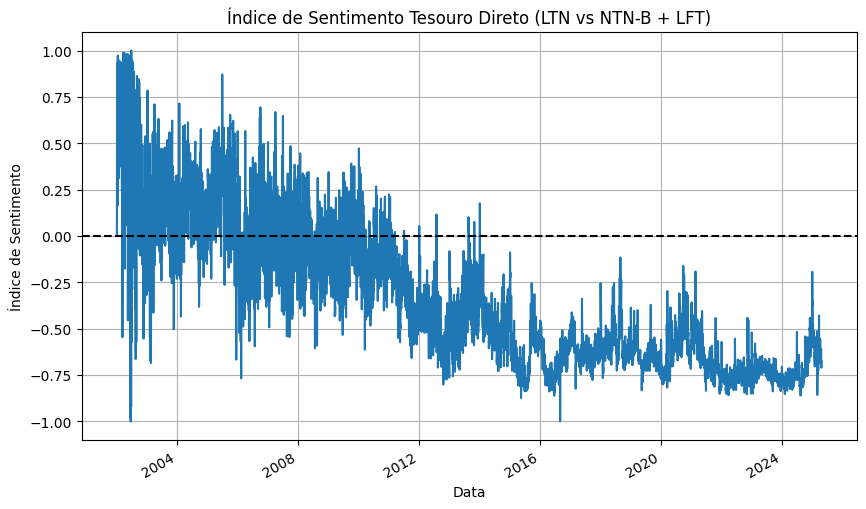

In [152]:
import matplotlib.pyplot as plt

pivot['Indice Sentimento'].plot(figsize=(10,6), title='Índice de Sentimento Tesouro Direto (LTN vs NTN-B + LFT)')
plt.axhline(0, color='black', linestyle='--')
plt.ylabel('Índice de Sentimento')
plt.xlabel('Data')
plt.grid(True)
plt.show()
